In [79]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [93]:
# Thor DataLoad
# Specify the path to the manually downloaded dataset
data_dir = r'C:\Users\thorp\OneDrive\Dokumenter\Uni\Kandidat\Anvendt maskinlæring\Exam\Data\patch_camelyon'

# Load PatchCamelyon dataset using TFDS
dataset_name = 'patch_camelyon'
dataset, info = tfds.load(name=dataset_name, split='train', with_info=True, data_dir=data_dir)


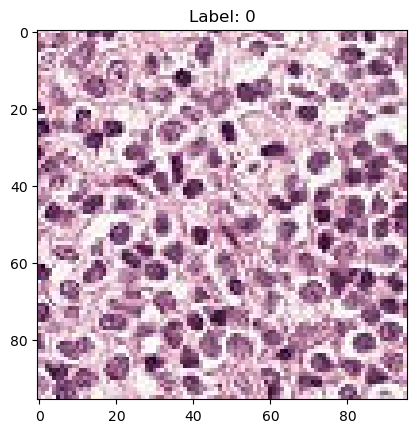

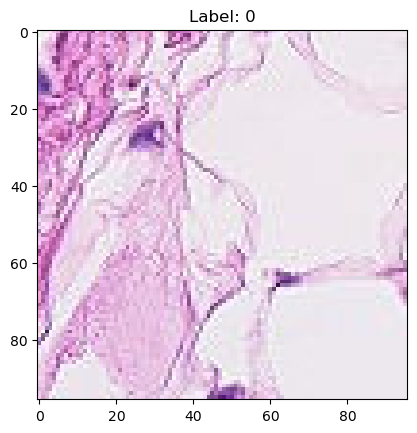

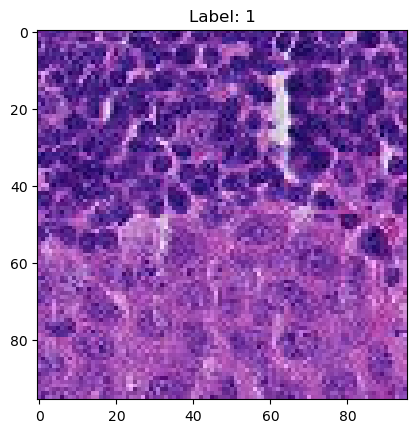

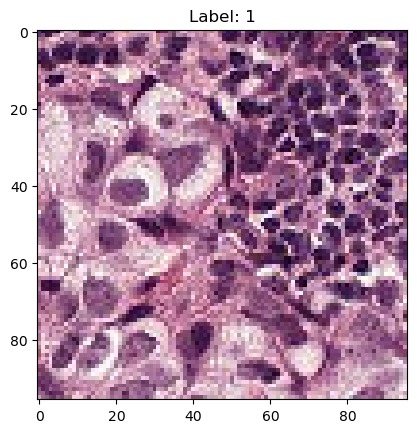

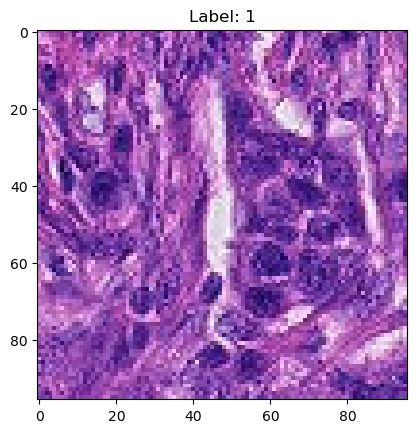

In [94]:
num_samples_to_display = 5
samples = dataset.take(num_samples_to_display)
for sample in samples:
    image = sample['image'].numpy()
    label = sample['label'].numpy()

    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.show()

In [84]:
# Extract features (X) and labels (y) from the dataset
# Note: This example assumes that your dataset has features and labels
def preprocess_data(example):
    return example['image'], example['label']

# Apply the preprocessing function to the dataset
dataset = dataset.map(preprocess_data)

# Convert the dataset to NumPy arrays
data = list(dataset.as_numpy_iterator())
X = [item[0] for item in data]
y = [item[1] for item in data]

# Perform train-test split using scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
#10% extracted
# Take only 10% of the loaded dataset
percentage = 0.1
num_examples_10_percent = int(percentage * info.splits['train'].num_examples)
dataset_10_percent = X_train.take(num_examples_10_percent)

# Display information about the original and subset datasets
print("Original number of examples:", info.splits['train'].num_examples)
print("Number of examples in 10% subset:", num_examples_10_percent)

Original number of examples: 262144
Number of examples in 10% subset: 26214


In [72]:
# Split into train and test datasets
train_size = int(0.8 * num_examples_10_percent)
test_size = num_examples_10_percent - train_size

train_dataset = dataset_10_percent.take(train_size)
test_dataset = dataset_10_percent.skip(train_size)

In [73]:
# Retrieve an element from the train dataset
sample_element_train = next(iter(train_dataset))
image_shape_train = sample_element_train['image'].shape
label_shape_train = sample_element_train['label'].shape

# Retrieve an element from the test dataset
sample_element_test = next(iter(test_dataset))
image_shape_test = sample_element_test['image'].shape
label_shape_test = sample_element_test['label'].shape

# Print the shapes
print("Train dataset - Image shape:", image_shape_train, "Label shape:", label_shape_train)
print("Test dataset - Image shape:", image_shape_test, "Label shape:", label_shape_test)

Train dataset - Image shape: (96, 96, 3) Label shape: ()
Test dataset - Image shape: (96, 96, 3) Label shape: ()


In [25]:
input_shape = (96,96,3)

In [15]:
""" API load 
#API load
import tensorflow as tf
import tensorflow_datasets as tfds

# Load 10% of the PatchCamelyon dataset using TFDS
dataset_name = 'patch_camelyon'
percentage = 10

# Define the split using tfds.percent
split = f'train[:{percentage}%]'

# Load the entire PatchCamelyon dataset with a different data directory
dataset_name = 'patch_camelyon'
data_dir = r'C:\Users\thorp\OneDrive\Dokumenter\Data AML'
dataset, info = tfds.load(name=dataset_name, split='train', with_info=True, data_dir=data_dir)

# Display dataset information
print("Number of examples in 10% subset:", info.splits['train'].num_examples)
"""

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [95]:
# Display dataset information
print("Dataset name:", info.name)
print("Number of classes:", info.features['label'].num_classes)
print("Class names:", info.features['label'].names)
print("Number of examples:", info.splits['train'].num_examples)
print("Image shape:", info.features['image'].shape)
print("Dataset description:", info.description)

Dataset name: patch_camelyon
Number of classes: 2
Class names: ['0', '1']
Number of examples: 262144
Image shape: (96, 96, 3)
Dataset description: The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.


**Problem 1:** 

During the semester you have become very excited about working on the PatchCamelyon (PCam) 
data. Like Veeling et al (2018), you are primarily interested in developing machine learning models that, based on patches of whole-slide images of lymph node sections, can assist pathologists in 
tumor detection.  

The primary objective of this exam is to perform image classification on the PCam dataset, with a 
focus on using autoencoders for image compression.  As a reminder, the PCAM dataset consists of 327,680 color images (96x96pxs) extracted from 
histopathologic scans of lymph node sections. Each image is annotated with a binary label 
indicating presence of metastatic tissue. Specifically, the dataset is divided into 262,144 training 
images, 32,768 validation images, and 32,768 test images. You must use the training/validation 
images to train/validate models that perform well at classifying the test images. Importantly, you are not required to use the full dataset. Use the amount of data that is feasible for you and your hardware configuration.

The PCam dataset is available from many online sources but 
some of them are very slow. Therefore, I recommend accessing the dataset from my SDU 
repository: Link to PCAM. Further instructions and hints on how to load the data efficiently and flexibly by using the module tfds|Tensorflow Dataset are available on the course site’s itslearning platform.

Questions:

You wish to perform image classification. However, you are a little concerned about the size of the 
PCAM images. Their size might be too demanding for your hardware configuration, potentially 
hindering proper hyperparameter tuning and downstream model evaluation. Hence, you wish as a 
pre-processing step to compress the images by using autoencoders (both AEs and VAEs).

1. Discuss how you can use autoencoders to compress images. Motivate why you think 
compressing the images by using AE/VAE will work here and will be better than just simple 
resizing for example by using the function:  

**Initial AE**

In [48]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=(96,96,3), activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'), # this is the bottleneck layer
], name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=(96,96,3), activation='relu'), 
    # 5 since we compress features into 5 neurons
    tf.keras.layers.Dense(20), 
    # map back to 20 as we have 20 features and want to reconstruct these
], name='decoder')

autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

ValueError: Exception encountered when calling layer "decoder" (type Sequential).

Input 0 of layer "dense_54" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 96, 96, 5)

Call arguments received by layer "decoder" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 96, 96, 5), dtype=float32)
  • training=None
  • mask=None

In [49]:
# Encoder
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(96, 96, 3)),  # Flatten the image to a vector
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),  # Bottleneck layer
], name='encoder')

# Decoder
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation='relu', input_shape=(5,)),  # Decoder takes the bottleneck layer as input
    tf.keras.layers.Dense(96 * 96 * 3, activation='sigmoid'),  # Output layer, sigmoid for image reconstruction
    tf.keras.layers.Reshape((96, 96, 3)),  # Reshape back to image shape
], name='decoder')

# Autoencoder
autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')


In [50]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense_56 (Dense)            (None, 30)                829470    
                                                                 
 dense_57 (Dense)            (None, 5)                 155       
                                                                 
Total params: 829,625
Trainable params: 829,625
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 30)                180       
                                                                 
 dense_59 (Dense)            (None, 

In [69]:
sample_batch = next(iter(train_dataset))
#input_shape = sample_batch[0].shape[1:]  # Exclude batch dimension
print(sample_batch)

StopIteration: 

In [51]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [52]:
# Normalize and preprocess the images
def preprocess(example):
    image, label = example['image'], example['label']
    # Normalize pixel values to the range [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image as both input and target for autoencoder

# Apply preprocessing and batching to the dataset
batch_size = 32
dataset_processed = dataset_10_percent.map(preprocess).batch(batch_size)

# Train the autoencoder on the PatchCamelyon dataset
autoencoder.fit(dataset_processed, epochs=5)

Epoch 1/5
820/820 [==============================] - 34s 41ms/step - loss: 0.6482
Epoch 2/5
820/820 [==============================] - 33s 40ms/step - loss: 0.6396
Epoch 3/5
820/820 [==============================] - 34s 41ms/step - loss: 0.6396
Epoch 4/5
820/820 [==============================] - 34s 42ms/step - loss: 0.6396
Epoch 5/5
820/820 [==============================] - 34s 42ms/step - loss: 0.6396


Sample Variational Autoencoder

In [53]:
latent_dim = 2
v_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, 2, activation='relu', input_shape=(96, 96, 3)),
    tf.keras.layers.Conv2D(64, 3, 2, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2 * latent_dim), # 2 since we encode mean and standard deviation
])
v_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=7*7*32, activation='relu', input_shape=(latent_dim,)),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)), # To get in "image format"
    tf.keras.layers.Conv2DTranspose(64, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', activation='relu'),
    tf.keras.layers.Conv2DTranspose(1, 3, 1, padding='same'),
])

In [55]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    vals = -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(vals, axis=raxis)

def compute_loss(model, x):
    # Output from encoder
    mean, logvar = model.encode(x)    
    # The reparameterization trick
    z = model.reparameterize(mean, logvar)    
    # We assume that p(x|z) is multivariate Bernoulli, ie. the final dense layer 
    # has a sigmoid activation function, see page. 11
    # in Kingma, D. P., & Welling, M. (2013).
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, 
                                                        labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])    
    # Assume normaility of p(z)
    logpz = log_normal_pdf(z, 0., 0.)    
    # Assume normality of q(z|x)
    logqz_x = log_normal_pdf(z, mean, logvar)
    # -tf.reduce_mean(decoder + sampler - encoder)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [56]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = v_encoder
        self.decoder = v_decoder
    
    def encode(self, x):
        params = self.encoder(x)
        return tf.split(params, num_or_size_splits=2, axis=1) # mean, logvar
        
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean #sigma= sqrt(exp(logvar))
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return tf.sigmoid(self.decode(eps))

In [57]:
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [58]:
for epoch in range(10):
    for train_x in dataset_10_percent:
        train_step(model, train_x, optimizer)

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    variational_lower_bound = -loss.result()

    print(f'Epoch: {epoch}, Test set variational lower bound:
           {variational_lower_bound}')
    generate_and_save_images(model, epoch, test_sample)

SyntaxError: unterminated string literal (detected at line 10) (3815896794.py, line 10)